# Analyzing ATP Pro Tennis Players Dataset

In [0]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import pandas_profiling
import matplotlib.pyplot as plt

## Load, Clean and Merge Datasets

In [0]:
# merge all ranked ATP players
df_rank_80 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_80s.csv")
df_rank_90 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_90s.csv")
df_rank_00 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_00s.csv")
df_rank_10 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_10s.csv")
df_rank_19 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_current.csv")

dfs_rank = [df_rank_80, df_rank_90, df_rank_00, df_rank_10, df_rank_19]

df_rank = pd.concat(dfs_rank, axis=0, sort=False, join='outer')

# rename player and country columns, added name column
df_rank = df_rank.rename(columns={'player': 'player_id'})
print(df_rank.shape)
df_rank.sample(5)

(2771191, 4)


,ranking_date,rank,player_id,points
63118,20001009,1351,103883,1.0
847042,20181126,1745,200320,1.0
119048,19870223,215,100837,NaN
72930,19910225,680,102111,10.0
349468,20131118,547,106033,58.0


In [0]:
# load players name df
df_players = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_players.csv")
# renaming columns and values
df_players = df_players.rename(columns={'country': 'country_id'})
# combine first and last name
df_players['name'] = df_players['name_first']+" "+df_players['name_list']
print(df_players.shape)
df_players.sample(5)

(54067, 7)


,player_id,name_first,name_list,hand,birthdate,country_id,name
47534,202500,Filip,Aerts,R,19710914.0,BEL,Filip Aerts
2766,102767,Pavel,Gajdzik,R,19760405.0,POL,Pavel Gajdzik
17153,117169,Rolf,Christoffersen,NaN,NaN,NOR,Rolf Christoffersen
7300,107315,Jean Van,Rensburg,R,NaN,RSA,Jean Van Rensburg
13516,113532,Henri,Rochon,NaN,NaN,CAN,Henri Rochon


In [0]:
# merge players name and id
atp_ranks = pd.merge(df_rank, df_players, how='inner', on='player_id')
# convert birthdate to integer first before calculating age
atp_ranks = atp_ranks.astype({"ranking_date": float}, errors='ignore')
atp_ranks['age'] = (atp_ranks['ranking_date']-atp_ranks['birthdate'])/10000

print(atp_ranks.shape)
# formats each row to the regular format, change to 'object' dtype
atp_ranks.age.describe().apply(lambda x: format(x, 'f'))
# min age not possible

(2771191, 12)


count    2582998.000000
mean          23.380708
std            4.189482
min          -14.031700
25%           20.038300
50%           22.979100
75%           25.990600
max           66.962300
Name: age, dtype: object

## Trim dataset to only top 100 ranked players

In [0]:
# no pro tennis players under 10 years old
# top 100 players all time over 10 years old
atp_100 = atp_ranks[(atp_ranks['rank']<=100)&(atp_ranks['age']>=10)]
print(atp_100.shape)
atp_100.describe()

(170789, 12)


,ranking_date,rank,player_id,points,birthdate,age,r_year
count,1.707890e+05,170789.000000,170789.000000,141682.000000,1.707890e+05,170789.000000,170789.000000
mean,2.001450e+07,50.500659,103011.041425,1178.383853,1.975525e+07,25.925500,2001.382648
std,9.746905e+04,28.867511,2811.818717,1253.013575,9.284237e+04,3.706945,9.747367
min,1.980122e+07,1.000000,100060.000000,224.000000,1.941120e+07,16.038400,1980.000000
25%,1.993082e+07,26.000000,101510.000000,591.000000,1.968082e+07,23.021200,1993.000000
50%,2.001112e+07,50.000000,102776.000000,797.000000,1.976042e+07,25.958200,2001.000000
75%,2.010012e+07,76.000000,104160.000000,1241.000000,1.983051e+07,28.070800,2010.000000
max,2.019022e+07,100.000000,200282.000000,16950.000000,2.000081e+07,40.930600,2019.000000


In [0]:
# convert integer date to proper date format
atp_100['r_date'] = atp_100['ranking_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
# set ranking year
atp_100['r_year'] = atp_100['r_date'].dt.year
# remove duplicates since 1984
dfs_single_100 = [atp_100[atp_100['r_year']==year].drop_duplicates(
                 ['name'], keep='last').drop_duplicates(
                 ['rank'], keep='last') for year in range(1984,2020)]
atp_100 = pd.concat(dfs_single_100, axis=0, sort=False, join='outer')

print(atp_100.shape)
atp_100.sample(5)

(3597, 14)


,ranking_date,rank,player_id,points,name_first,name_list,hand,birthdate,country_id,name,age,r_year,r_date,Region
16686,19871228.0,57,100942,NaN,Thierry,Tulasne,R,19630712.0,FRA,Thierry Tulasne,24.0516,1987,1987-12-28,Europe
361651,19971229.0,56,101475,550.0,Carlos,Costa,R,19680422.0,ESP,Carlos Costa,29.0807,1997,1997-12-29,Europe
1140680,20091228.0,22,103720,1600.0,Lleyton,Hewitt,R,19810224.0,AUS,Lleyton Hewitt,28.1004,2009,2009-12-28,Australia
621758,20041227.0,91,102344,452.0,Karol,Kucera,R,19740304.0,SVK,Karol Kucera,30.0923,2004,2004-12-27,Europe
1847004,20121231.0,33,105064,1112.0,Thomaz,Bellucci,L,19871230.0,BRA,Thomaz Bellucci,25.0001,2012,2012-12-31,South America


In [0]:
# bin countries into region
atp_100['Region'] = atp_100['country_id'].replace(
    ['ESP','FRA','GER','CZE','SWE','EST','GRE','SUI','GBR','SRB','CRO','AUT',
     'SVK','BUL','UKR','BEL','ROU','LAT','FIN','POR','DEN','POL','SLO','BLR',
     'LUX','HUN','LTU','BIH','NOR','YUG','MDA','GEO','MON','NED','ITA'],'Europe'
    ).replace(['JPN','THA','KAZ','IND','TPE','KOR','UZB','PHI','RUS','TUR',
               'CYP','ISR','ARM'],'Asia').replace(
    ['KEN','SEN','RSA','MAR','ZIM','TUN','NGR'],'Africa').replace(
    ['BAH','CAN','MEX','CRC','DOM','USA'],'North America').replace(
    ['BOL','CHI','ECU','URU','PER','COL','PAR','VEN','BRA','ARG'],
    'South America').replace(['AUS','NZL'],'Australia')
atp_100.sample(10)

,ranking_date,rank,player_id,points,name_first,name_list,hand,birthdate,country_id,name,age,r_year,r_date,Region
785045,20001225.0,76,102539,536.0,Bohdan,Ulihrach,R,19750223.0,CZE,Bohdan Ulihrach,25.1002,2000.0,2000-12-25,Europe
212759,19881219.0,19,100944,NaN,Mikael,Pernfors,R,19630716.0,SWE,Mikael Pernfors,25.0503,1988.0,1988-12-19,Europe
1861190,20181231.0,24,105138,1605.0,Roberto,Bautista Agut,R,19880414.0,ESP,Roberto Bautista Agut,30.0817,2018.0,2018-12-31,Europe
1477513,20150608.0,95,104216,553.0,Maximo,Gonzalez,R,19830720.0,ARG,Maximo Gonzalez,31.9888,2015.0,2015-06-08,South America
747515,20001225.0,99,102456,410.0,Felix,Mantilla,R,19740923.0,ESP,Felix Mantilla,26.0302,2000.0,2000-12-25,Europe
1140367,20031229.0,17,103720,1450.0,Lleyton,Hewitt,R,19810224.0,AUS,Lleyton Hewitt,22.1005,2003.0,2003-12-29,Australia
2459741,20190225.0,75,106415,729.0,Yoshihito,Nishioka,L,19950927.0,JPN,Yoshihito Nishioka,23.9298,2019.0,2019-02-25,Asia
76813,19881219.0,54,101073,NaN,Martin,Jaite,R,19641009.0,ARG,Martin Jaite,24.0210,1988.0,1988-12-19,South America
807640,20011231.0,29,102562,1091.0,Jiri,Novak,R,19750322.0,CZE,Jiri Novak,26.0909,2001.0,2001-12-31,Europe
65262,19871228.0,80,100848,NaN,Alberto,Tous,R,19620803.0,ESP,Alberto Tous,25.0425,1987.0,1987-12-28,Europe


In [0]:
# create dataframe for average top 100 players' age
age_data = []
for year in range(1984,2020):
  df_year = atp_100[atp_100['r_year']==year]
  age_100 = df_year.age
  age_mean = age_100.mean()
  age_data.append([df_year.iloc[-1]['r_date'], age_mean])
  
atp_age_100 = pd.DataFrame(age_data,columns=['date','Average Age'])
atp_age_100.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
date,1984-12-17 00:00:00,1985-12-30 00:00:00,1986-12-01 00:00:00,1987-12-28 00:00:00,1988-12-19 00:00:00,1989-12-18 00:00:00,1990-12-31 00:00:00,1991-12-30 00:00:00,1992-12-28 00:00:00,1993-12-13 00:00:00,1994-11-14 00:00:00,1995-12-25 00:00:00,1996-12-30 00:00:00,1997-12-29 00:00:00,1998-12-28 00:00:00,1999-12-27 00:00:00,2000-12-25 00:00:00,2001-12-31 00:00:00,2002-12-30 00:00:00,2003-12-29 00:00:00,2004-12-27 00:00:00,2005-12-26 00:00:00,2006-12-25 00:00:00,2007-12-31 00:00:00,2008-12-29 00:00:00,2009-09-07 00:00:00,2010-12-27 00:00:00,2011-12-26 00:00:00,2012-12-31 00:00:00,2013-12-30 00:00:00,2014-12-29 00:00:00,2015-12-28 00:00:00,2016-12-26 00:00:00,2017-12-25 00:00:00,2018-12-24 00:00:00,2019-02-25 00:00:00
Average Age,24.3374,23.7052,23.345,23.4253,23.5345,23.8844,23.8865,23.9222,23.7759,24.3344,24.7438,24.5144,24.6894,24.6238,25.0179,24.6491,25.068,24.748,24.8296,24.9664,25.0652,25.036,25.2845,25.5187,25.5305,25.8737,25.9737,26.3709,26.729,27.1689,27.4781,27.3651,27.7843,27.7831,27.2576,28.0988


## Graph average age of top 100 ranked players

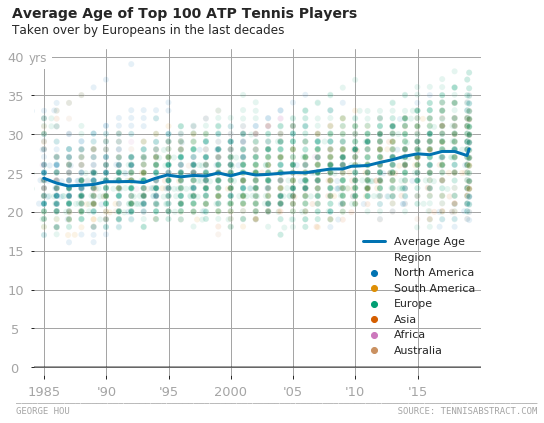

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
# set plot style
plt.style.use('fivethirtyeight')
# despine outer frame
sns.set()
sns.despine(left=True, bottom=True)
# set background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.grid(color='#A5A5A5')
ax.set(yticks=range(0, 50, 5), facecolor='white')
# Color palette
blue, = sns.color_palette("colorblind", 1)
# average age mean line
ax.plot(atp_age_100.date, atp_age_100['Average Age'], color=blue, lw=3)

# scatterplot of all 100 players' age
ax = sns.scatterplot(x="r_date", y="age", hue="Region", alpha=.1,
                     palette="colorblind", data=atp_100, legend='full')
# set x and y label
ax.set_xlabel('', fontsize=20, color='#A5A5A5')
ax.set_ylabel('', fontsize=20, color='#A5A5A5')
# modify y labels
ax.set_yticks([0, 5, 10, 15, 20,25,30,35,40])
ax.set_yticklabels(labels=['0 ','5 ','10','15','20','25','30','35','40'], 
                   fontsize=13, color='#A5A5A5')
# modify x labels
ax.set_xticks([pd.to_datetime('1985-1-1'), pd.to_datetime('1990-1-1'), 
               pd.to_datetime('1995-1-1'), pd.to_datetime('2000-1-1'), 
               pd.to_datetime('2005-1-1'), pd.to_datetime('2010-1-1'), 
               pd.to_datetime('2015-1-1')])
ax.set_xticklabels(labels=["1985","'90","'95","2000","'05","'10","'15"], 
                   fontsize=13, color='#A5A5A5')
# change size and color of tick labels, extend grid
plt.tick_params(axis='x',labelsize=13,labelcolor='#A5A5A5')
plt.tick_params(axis='y',labelsize=13,labelcolor='#A5A5A5')
# set x and y limits
ax.set(xlim=([pd.to_datetime('1984-3-15'), pd.to_datetime('2020-1-31')]), 
       ylim=(-1,41))
# bold y axis at 0
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.5)
# Text for Title
ax.text(x=pd.to_datetime('1982-6-1'), y=45, s="Average Age of Top 100 ATP Tennis Players", 
        fontsize=14, fontweight='bold');
# Text for Subtitle
ax.text(x=pd.to_datetime('1982-6-1'), y=43, s="Taken over by Europeans in the last decades", 
        fontsize=12);
# text for yrs next to 40
ax.text(x=pd.to_datetime('1983-10-1'), y=39.4, s="yrs", fontsize=12, color='#A5A5A5', 
        backgroundcolor = 'white')
# signature line at bottom
ax.text(x = pd.to_datetime('1982-10-1'), y = -4.5,
    s = '_________________________________________________________________________________________________',
    fontsize = 9, family='monospace', color = '#A5A5A5')
ax.text(x = pd.to_datetime('1982-10-1'), y = -6,
    s = 'GEORGE HOU                                                             SOURCE: TENNISABSTRACT.COM',
    fontsize = 9, family='monospace', color = '#A5A5A5')

# Put a legend to the right of the current axis
ax.legend(loc='lower right', bbox_to_anchor=(1.01, 0.03),
          fancybox=True, shadow=True);

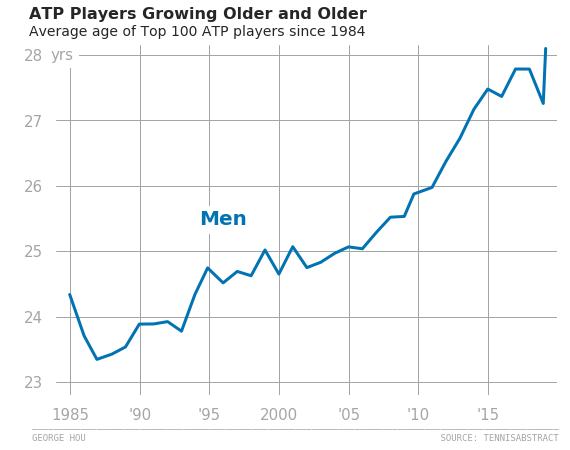

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
# set plot style
plt.style.use('fivethirtyeight')

# despine outer frame
sns.set()
sns.despine(left=True, bottom=True)

# set background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.grid(color='#A5A5A5')
ax.set(yticks=range(0, 50, 1), facecolor='white')

# Color palette
blue, = sns.color_palette("colorblind", 1)

# average age mean line
ax.plot(atp_age_100.date, atp_age_100['Average Age'], color=blue, lw=3)

# fill between upper std and lower bound std
# ax.fill_between(df_age_100.date, df_age_100.up_std, df_age_100.low_std, alpha=.2)

# set x and y label
ax.set_xlabel(' ',fontsize = 12,fontweight='semibold')
ax.set_ylabel(' ',fontsize = 12,fontweight='semibold')

# modify x labels
ax.set_xticks([pd.to_datetime('1985-1-1'), pd.to_datetime('1990-1-1'), 
               pd.to_datetime('1995-1-1'), pd.to_datetime('2000-1-1'), 
               pd.to_datetime('2005-1-1'), pd.to_datetime('2010-1-1'), 
               pd.to_datetime('2015-1-1')])
ax.set_xticklabels(labels=["1985","'90","'95","2000","'05","'10","'15"], 
                   fontsize=13, color='#A5A5A5')

# set x and y limits
ax.set_xlim([pd.to_datetime('1984-1-1'), pd.to_datetime('2019-12-31')])
ax.set_ylim([22.8, 28.15])

# change size and color of tick labels, extend grid
plt.tick_params(axis='x',labelsize=15,labelcolor='#A5A5A5', 
               color = '#A5A5A5')
plt.tick_params(axis = 'y', labelsize = 15, labelcolor = '#A5A5A5')

# Text for Title
ax.text(x=pd.to_datetime('1982-1-1'), y=28.55, s="ATP Players Growing Older and Older", 
        fontsize=16, fontweight='bold');

# Text for Subtitle
ax.text(x=pd.to_datetime('1982-1-1'), y=28.30,
        s="Average age of Top 100 ATP players since 1984", fontsize=14);

# text for yrs next to 40
ax.text(x=pd.to_datetime('1983-8-1'), y=27.925, s="yrs", fontsize=15, 
        color='#A5A5A5',backgroundcolor = 'white')

# text for average age
ax.text(x=pd.to_datetime('1994-4-1'), y=25.4, s="Men", fontsize=20, 
        color=blue, fontweight='semibold',backgroundcolor = 'white')

# signature line at bottom
ax.text(x =pd.to_datetime('1982-4-1'), y=22.3,
    s = '__________________________________________________________________________________________________',
    fontsize = 9, family='monospace', color = '#A5A5A5')
ax.text(x =pd.to_datetime('1982-4-1'), y=22.1,
    s = 'GEORGE HOU                                                                  SOURCE: TENNISABSTRACT',
    fontsize = 9, family='monospace', color = '#A5A5A5')

# bold y axis at 0
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.5);